## Building, Demonstrating RBF Net against a Single-layer Neural Net

In this notebook the simple R [neuralnet](https://cran.r-project.org/web/packages/neuralnet/neuralnet.pdf) package's single-layer neural network is compared against an implementation of a RBF network.

The motivation is to demonstrate the efficacy of radial basis functions on highly non-linearly seperated data for which single-layer neural networks of few hidden nodes struggle with.

In [2]:
install.packages("corpcor")

Installing package into 'C:/Users/herzf/R/win-library/3.6'
(as 'lib' is unspecified)



package 'corpcor' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\herzf\AppData\Local\Temp\RtmpMlUq0o\downloaded_packages


In [3]:
library("corpcor")
library("neuralnet")

rbf <- function(X, Y, K=5, gamma=1.0) {
  N<- dim(X)[1] # number of instances
  
  repeat {
    km <- kmeans(X, K)  # let's cluster K centers out of the dataset
    if (min(km$size)>0) # only accept if there are no empty clusters
      break
  }
  mus <- km$centers # the clusters points
  
  Phi <- matrix(rep(NA,(K+1)*N), ncol=K+1)
  for (lin in 1:N) {
    Phi[lin,1] <- 1    # bias column
    for (col in 1:K) {
      Phi[lin,col+1] <- exp( -gamma * norm(as.matrix(X[lin,]-mus[col,]),"F")^2 )
    }
  }
#  w <- pseudoinverse(t(Phi) %*% Phi) %*% t(Phi) %*% matrix(as.numeric(Y))  # find RBF weights
  w <- pseudoinverse(Phi) %*% matrix(as.numeric(Y))  # find RBF weights
  list(weights=w, centers=mus, gamma=gamma)  # return the rbf model
}

rbf.predict <- function(model, X, classification=FALSE) {  
  gamma   <- model$gamma
  centers <- model$centers
  w       <- model$weights
  N       <- dim(X)[1]    # number of observations
  
  pred <- rep(w[1],N)  # we need to init to a value, so let's start with the bias
  for (j in 1:N) {  
    # find prediction for point xj
    for (k in 1:length(centers[,1])) {
      # the weight for center[k] is given by w[k+1] (because w[1] is the bias)
      pred[j] <- pred[j] + w[k+1] * exp( -gamma * norm(as.matrix(X[j,]-centers[k,]),"F")^2 )
    }
  }
  
  if (classification) {
    pred <- unlist(lapply(pred, sign))
  }
  return(pred)
}


circle<-read.table("circle.txt",sep=",",header=T)
circle

Warning message:
"package 'neuralnet' was built under R version 3.6.3"


V1,V2,labels
<dbl>,<dbl>,<int>
-0.36125433,0.77676658,1
0.35104327,-0.83239241,1
-0.35627285,0.92975989,1
-0.03069027,-0.18070132,-1
0.94496021,0.97921835,1
-0.70625080,-0.99694213,1
0.99161877,0.99690349,1
0.83584269,0.30713464,1
-0.17736194,0.90564358,1


Show plot of all instances

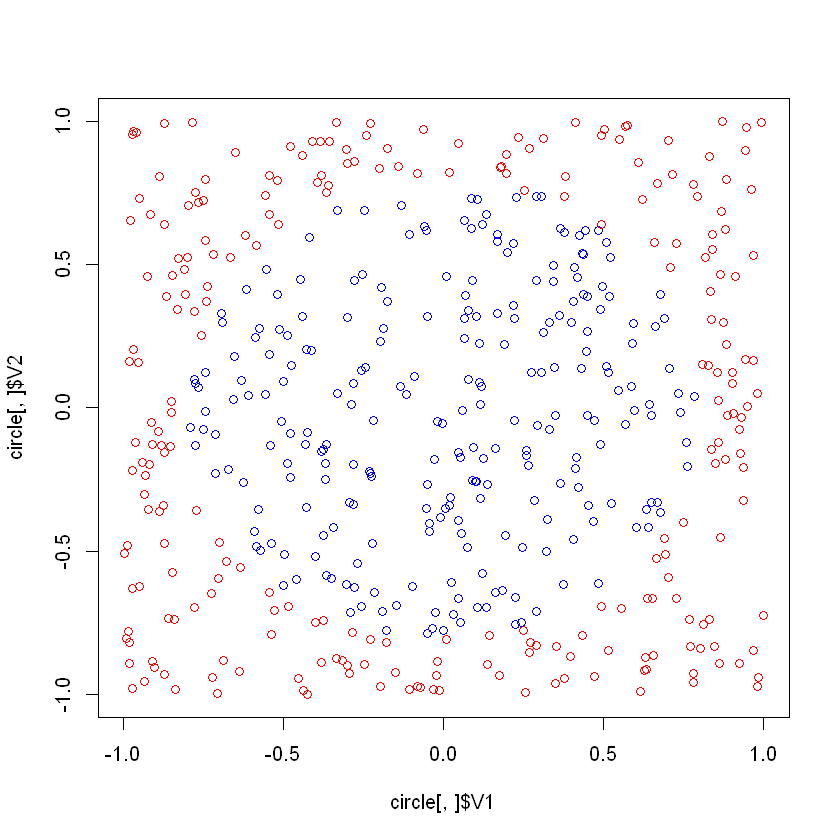

In [4]:
plot(circle[,]$V1,circle[,]$V2,xlim=c(-1,1),ylim=c(-1,1),col=c("blue","black","red")[circle[,]$labels+2])

Train RBF Network, Evaluate RBF Network, Plot Performance

In [11]:
# Split training and test datasets
labels.index <- dim(circle)[2]
indexes <- sample(nrow(circle), 0.3*nrow(circle))

training.set <- circle[indexes,]
test.set <- circle[-indexes,]

training.set
test.set

,V1,V2,labels
,<dbl>,<dbl>,<int>
425,-0.9896683022,-0.478658034,1
153,0.5658619790,0.980580316,1
200,-0.9354805714,-0.301646588,1
418,0.0160750258,-0.341284289,-1
163,0.9412241592,0.897176370,1
44,0.6069983826,0.857756048,1
137,0.5964386724,-0.007048026,-1
354,0.3771620584,0.739209653,1
455,-0.6257955697,-0.259296198,-1


,V1,V2,labels
,<dbl>,<dbl>,<int>
2,0.35104327,-0.83239241,1
4,-0.03069027,-0.18070132,-1
6,-0.70625080,-0.99694213,1
7,0.99161877,0.99690349,1
8,0.83584269,0.30713464,1
10,-0.17756695,0.37130143,-1
14,0.48410537,-0.61154208,-1
15,-0.30480615,-0.61528897,-1
17,0.21920208,0.31123623,-1


In [12]:
training.set[,labels.index]

[1]  1  1  1 -1  1  1 -1  1 -1 -1 -1  1  1  1  1  1  1 -1  1 -1 -1  1 -1 -1  1
 [26]  1 -1  1 -1 -1  1  1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1
 [51] -1  1  1 -1  1  1 -1 -1 -1  1 -1 -1  1 -1 -1  1  1  1 -1  1  1 -1  1  1 -1
 [76] -1 -1 -1  1 -1  1  1  1  1  1 -1 -1  1  1 -1 -1  1  1 -1  1 -1  1 -1  1  1
[101] -1  1  1 -1 -1  1 -1 -1 -1 -1  1  1  1  1  1  1 -1  1 -1 -1  1 -1  1 -1  1
[126] -1 -1  1 -1  1  1  1  1  1 -1  1 -1  1 -1 -1 -1 -1 -1 -1  1 -1  1  1 -1 -1

In [13]:
centers.vector <- c(3, 5, 10)
rbf.classifier <- list()
i = 1

for(centers in centers.vector){
    rbf.classifier[[i]] <- rbf(training.set[,-labels.index],training.set[,labels.index], K=centers)
    i = i + 1
}

In [14]:
rbf.predictions <- list()

for(i in 1:length(centers.vector)){
    rbf.predictions[[i]] <- rbf.predict(rbf.classifier[[i]], test.set[,-labels.index], T)
    print(rbf.predictions[[i]])
    cat("\n")
}

  [1]  1 -1  1  1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  1  1 -1  1  1 -1  1 -1  1 -1
 [26] -1  1 -1 -1 -1  1 -1  1  1  1  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1  1  1  1
 [51] -1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1  1  1
 [76] -1 -1 -1  1 -1 -1 -1  1 -1  1 -1 -1  1  1 -1  1  1  1 -1 -1 -1 -1 -1  1  1
[101] -1 -1  1 -1 -1  1  1  1 -1 -1  1 -1  1 -1 -1 -1  1  1 -1 -1  1  1 -1  1  1
[126] -1  1  1 -1  1 -1 -1  1  1  1 -1  1 -1  1  1 -1  1 -1  1 -1  1  1  1  1  1
[151] -1  1  1  1  1  1 -1 -1  1  1  1  1  1 -1 -1 -1  1 -1 -1  1 -1  1  1  1 -1
[176] -1 -1  1 -1  1 -1 -1  1  1  1  1  1  1 -1  1 -1 -1 -1  1  1  1 -1 -1 -1 -1
[201] -1  1 -1  1  1 -1  1  1  1  1 -1 -1 -1  1 -1 -1 -1  1 -1  1  1 -1  1  1 -1
[226] -1  1 -1 -1 -1  1 -1  1 -1  1 -1 -1  1  1  1  1 -1 -1  1  1 -1  1 -1 -1 -1
[251] -1 -1 -1 -1 -1  1  1 -1  1  1 -1  1  1 -1  1 -1  1  1 -1  1 -1 -1  1  1 -1
[276]  1  1  1  1  1 -1  1  1 -1  1  1 -1  1  1 -1 -1  1 -1 -1 -1  1  1  1 -1 -1
[301] -1  1  1  1 -1 -1 -1 -

In [15]:
# Calculating and printing accuracy, tt
for(i in 1:length(centers.vector)){
    tt <- table(test.set[,labels.index], rbf.predictions[[i]])
    acc<-(tt[1][1]+tt[4][1])/sum(tt)
    caption<-sprintf("RBF Accuracy: %.4f",acc)
    print(caption)
    print(tt)
    cat("\n")
}

[1] "RBF Accuracy: 0.9371"
    
      -1   1
  -1 164  10
  1   12 164

[1] "RBF Accuracy: 0.9686"
    
      -1   1
  -1 169   5
  1    6 170

[1] "RBF Accuracy: 0.9571"
    
      -1   1
  -1 163  11
  1    4 172



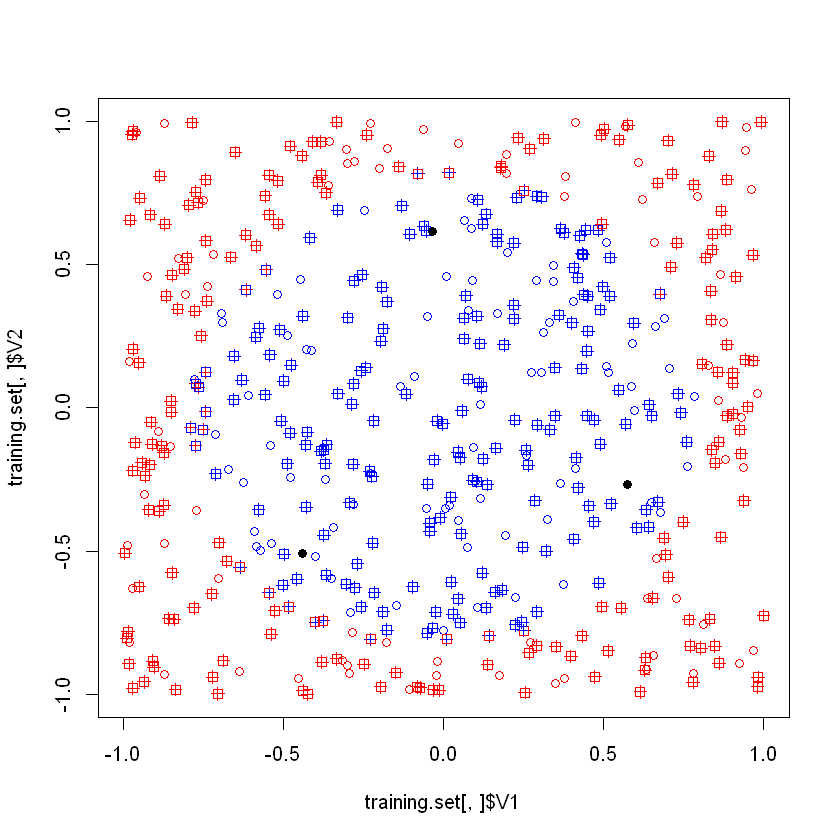

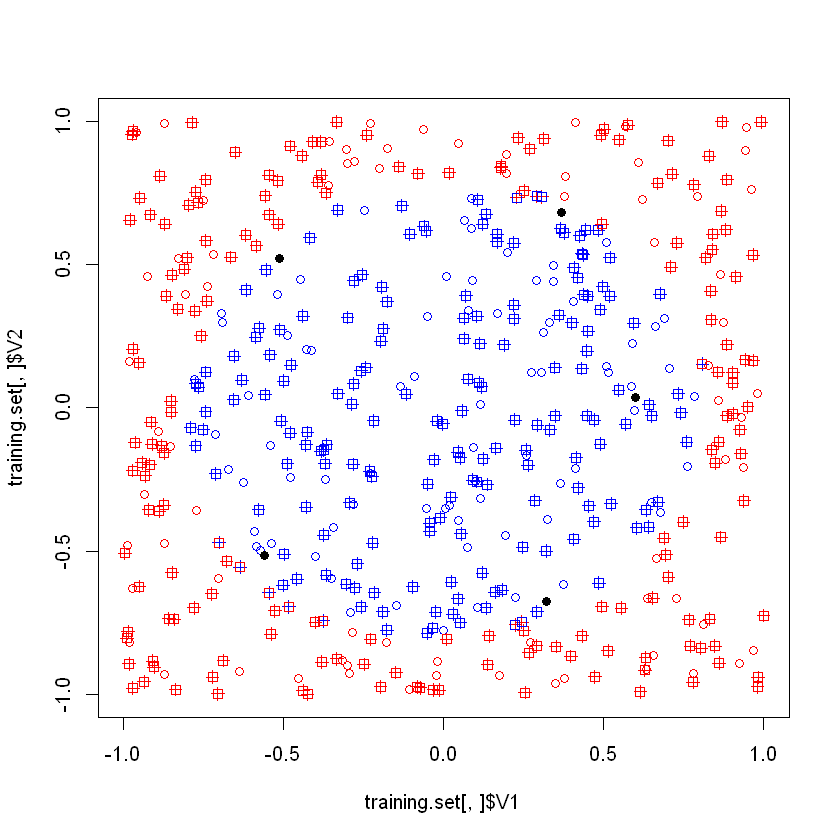

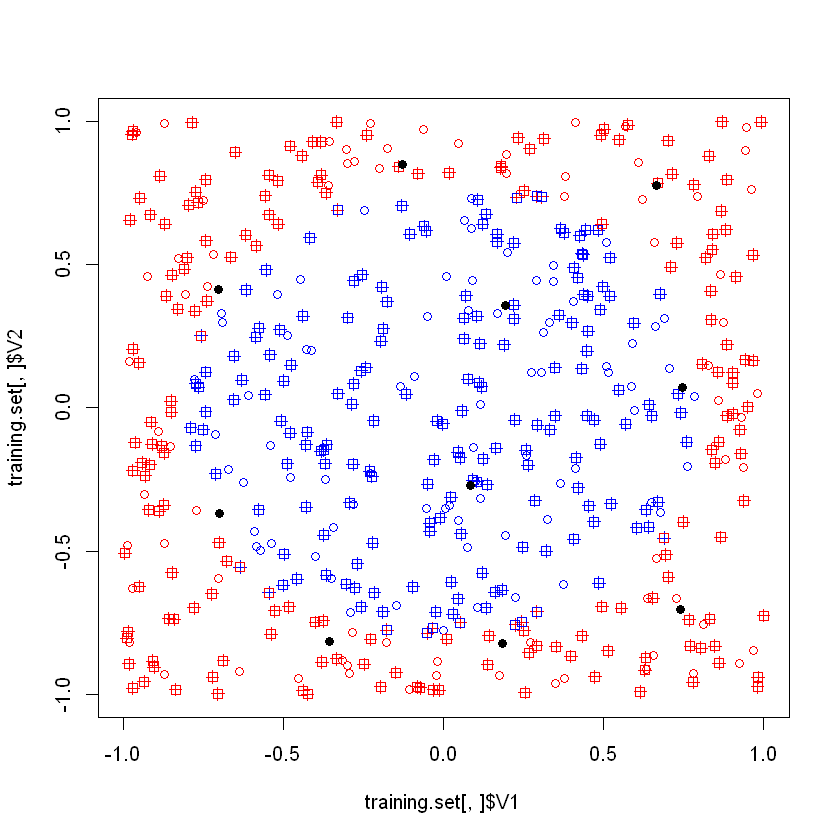

In [16]:
# Plot graphs for all architectures
for(i in 1:length(centers.vector)){
    plot(training.set[,]$V1,training.set[,]$V2,xlim=c(-1,1),ylim=c(-1,1),col=c("blue","black","red")[training.set[,labels.index]+2])
    points(test.set[,1],test.set[,2],col=c("blue","black","red")[rbf.predictions[[i]][]+2],pch=3)
    points(test.set[,1],test.set[,2],col=c("blue","black","red")[test.set[,labels.index]+2],pch=0)
    points(rbf.classifier[[i]]$centers, col="black", pch=19) 
}

Train One Hidden Layer Network and Report Accuracy

In [17]:
net.architectures <- c(2, 5, 10)
net.classifier <- list()
i = 1

# Train Models
for(arch in net.architectures){
    net.classifier[[i]] <- neuralnet(labels~V1+V2, training.set, hidden=arch)
    i = i + 1
}
summary(net.classifier[[1]])

                    Length Class      Mode    
call                  4    -none-     call    
response            150    -none-     numeric 
covariate           300    -none-     numeric 
model.list            2    -none-     list    
err.fct               1    -none-     function
act.fct               1    -none-     function
linear.output         1    -none-     logical 
data                  3    data.frame list    
exclude               0    -none-     NULL    
net.result            1    -none-     list    
weights               1    -none-     list    
generalized.weights   1    -none-     list    
startweights          1    -none-     list    
result.matrix        12    -none-     numeric 

In [18]:
net.predictions <- list()

# Predict from models
for(i in 1:length(net.classifier)){
    net.predictions[[i]] <- predict(net.classifier[[i]], test.set[,-labels.index])
    net.predictions[[i]] <- ifelse(net.predictions[[i]]>0.5,1,-1)
    
    # Output TT and Accuracy
    tt <- table(test.set[,labels.index], net.predictions[[i]])
    acc <- (tt[1][1]+tt[4][1])/sum(tt)
    caption<-sprintf("One Hidden Layer (%d nodes) NN Accuracy: %.4f",net.architectures[[i]], acc)
    print(caption)
    print(tt)
    cat("\n")
}

[1] "One Hidden Layer (2 nodes) NN Accuracy: 0.7371"
    
      -1   1
  -1 153  21
  1   71 105

[1] "One Hidden Layer (5 nodes) NN Accuracy: 0.8457"
    
      -1   1
  -1 170   4
  1   50 126

[1] "One Hidden Layer (10 nodes) NN Accuracy: 0.9000"
    
      -1   1
  -1 174   0
  1   35 141



The RBF networks, regardless of whether there was 3, 5, or 10 centers, performed better than all single-layer FFNN, as reported by their accuracies. The best neural net accuracy value was approximately 90% while the worst RBF network performance was approximately 93%.
Furthermore, the time to train for the RBF network was drastically lower, especially when considering the FFNN and RBF configurations at 10 nodes and centers respectively.
RBF networks perform well in building higher dimensional spaces using non-linear transformations, which is well suited for the circle dataset.